# GraphRAG Knowledge Graph Exploration

This notebook helps you explore the knowledge graph built by GraphRAG v1.2.0.

**Prerequisites:**
- Run `.\run_index.ps1` to build the knowledge graph
- Ensure output files exist in `output/` directory (create_final_*.parquet files)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path

# Set up paths
output_dir = Path("..") / "output"

print(f"📂 Output directory: {output_dir}")
print(f"   Exists: {output_dir.exists()}")

📂 Output directory: ..\output
   Exists: True


## 1. Load Entities

In [5]:
# Load entities (GraphRAG v1.2.0 uses create_final_entities.parquet)
entities_df = pd.read_parquet(output_dir / "create_final_entities.parquet")

print(f"📊 Total Entities: {len(entities_df)}")
print(f"\n🏷️  Entity Types:")
print(entities_df['type'].value_counts())

entities_df.head()

📊 Total Entities: 40

🏷️  Entity Types:
type
PERSON          18
ORGANIZATION    11
                 5
EVENT            3
DOCUMENT         3
Name: count, dtype: int64


,id,human_readable_id,title,type,description,text_unit_ids
0,cb38ac82-b862-4f3b-ae53-cea79f930a1a,0,TECHVENTURE INC.,ORGANIZATION,TechVenture Inc. is a mid-sized technology com...,[c46263af364a655dbe883f362fd8d737473092164736d...
1,73c7dce6-5ec2-4d13-affe-a1e970d2e736,1,SARAH CHEN,PERSON,Sarah Chen is the Chief Executive Officer (CEO...,[c46263af364a655dbe883f362fd8d737473092164736d...
2,62d3edbb-841e-4ac6-bd1e-2e8019a68092,2,MICHAEL RODRIGUEZ,PERSON,Michael Rodriguez is the Chief Technology Offi...,[c46263af364a655dbe883f362fd8d737473092164736d...
3,a67f807d-010f-4a65-a163-bbe378d273bd,3,LISA WANG,PERSON,Lisa Wang is the Chief Operating Officer (COO)...,[c46263af364a655dbe883f362fd8d737473092164736d...
4,4923f2d7-201d-4adc-b01e-a028181900ed,4,DR. EMILY HARRISON,PERSON,Dr. Emily Harrison is the Head of AI Research ...,[c46263af364a655dbe883f362fd8d737473092164736d...


## 2. Load Relationships

In [6]:
# Load relationships (GraphRAG v1.2.0 uses create_final_relationships.parquet)
relationships_df = pd.read_parquet(output_dir / "create_final_relationships.parquet")

print(f"🔗 Total Relationships: {len(relationships_df)}")
print(f"\n📈 Relationship Types:")
if 'description' in relationships_df.columns:
    print(relationships_df['description'].value_counts().head(10))
else:
    print("No relationship types found")

relationships_df.head()

🔗 Total Relationships: 132

📈 Relationship Types:
description
Sarah Chen is the CEO and founder of TechVenture Inc.                                                                                                                                                                                                                            1
Nina Kowalski works on backend services for Project Alpha                                                                                                                                                                                                                        1
Amanda Foster is actively involved in Project Alpha, where she contributes significantly to the product and design aspects of the project. Her role encompasses both creative and strategic elements, ensuring that Project Alpha benefits from her expertise in these areas.    1
Jennifer Park is responsible for infrastructure and cloud services for Project Alpha                             

,id,human_readable_id,source,target,description,weight,combined_degree,text_unit_ids
0,340f5a7d-d628-464f-9265-7e16f7a3f856,0,TECHVENTURE INC.,SARAH CHEN,Sarah Chen is the CEO and founder of TechVentu...,18.0,24,[c46263af364a655dbe883f362fd8d737473092164736d...
1,f277e588-cc75-4709-b3bb-58485c3bc8e2,1,TECHVENTURE INC.,MICHAEL RODRIGUEZ,Michael Rodriguez is the CTO of TechVenture Inc.,17.0,29,[c46263af364a655dbe883f362fd8d737473092164736d...
2,af444aeb-fe3a-4a8b-bae6-af3bc09f9cc8,2,TECHVENTURE INC.,LISA WANG,Lisa Wang is the COO of TechVenture Inc.,17.0,25,[c46263af364a655dbe883f362fd8d737473092164736d...
3,d333ce99-ff7d-4869-9f10-b7079a013b2c,3,TECHVENTURE INC.,DR. EMILY HARRISON,Dr. Emily Harrison is the Head of AI Research ...,9.0,26,[c46263af364a655dbe883f362fd8d737473092164736d...
4,620a2bfb-f0d3-4719-9f95-6e7bccb58f6a,4,TECHVENTURE INC.,DR. JAMES MITCHELL,Dr. James Mitchell is a Senior ML Engineer at ...,9.0,20,[c46263af364a655dbe883f362fd8d737473092164736d...


## 3. Visualize Knowledge Graph

Create a network graph visualization of entities and relationships.

In [7]:
# Create a NetworkX graph
G = nx.Graph()

# Add nodes (entities) - use 'title' column in v1.2.0
for idx, row in entities_df.iterrows():
    G.add_node(row['title'], type=row['type'])

# Add edges (relationships) - limit to top relationships for visualization
top_relationships = relationships_df.head(50)  # Limit for readability
for idx, row in top_relationships.iterrows():
    if 'source' in row and 'target' in row:
        G.add_edge(row['source'], row['target'], relationship=row.get('description', 'related'))

print(f"📊 Graph Stats:")
print(f"   Nodes: {G.number_of_nodes()}")
print(f"   Edges: {G.number_of_edges()}")
if G.number_of_nodes() > 1:
    print(f"   Density: {nx.density(G):.4f}")

📊 Graph Stats:
   Nodes: 40
   Edges: 45
   Density: 0.0577


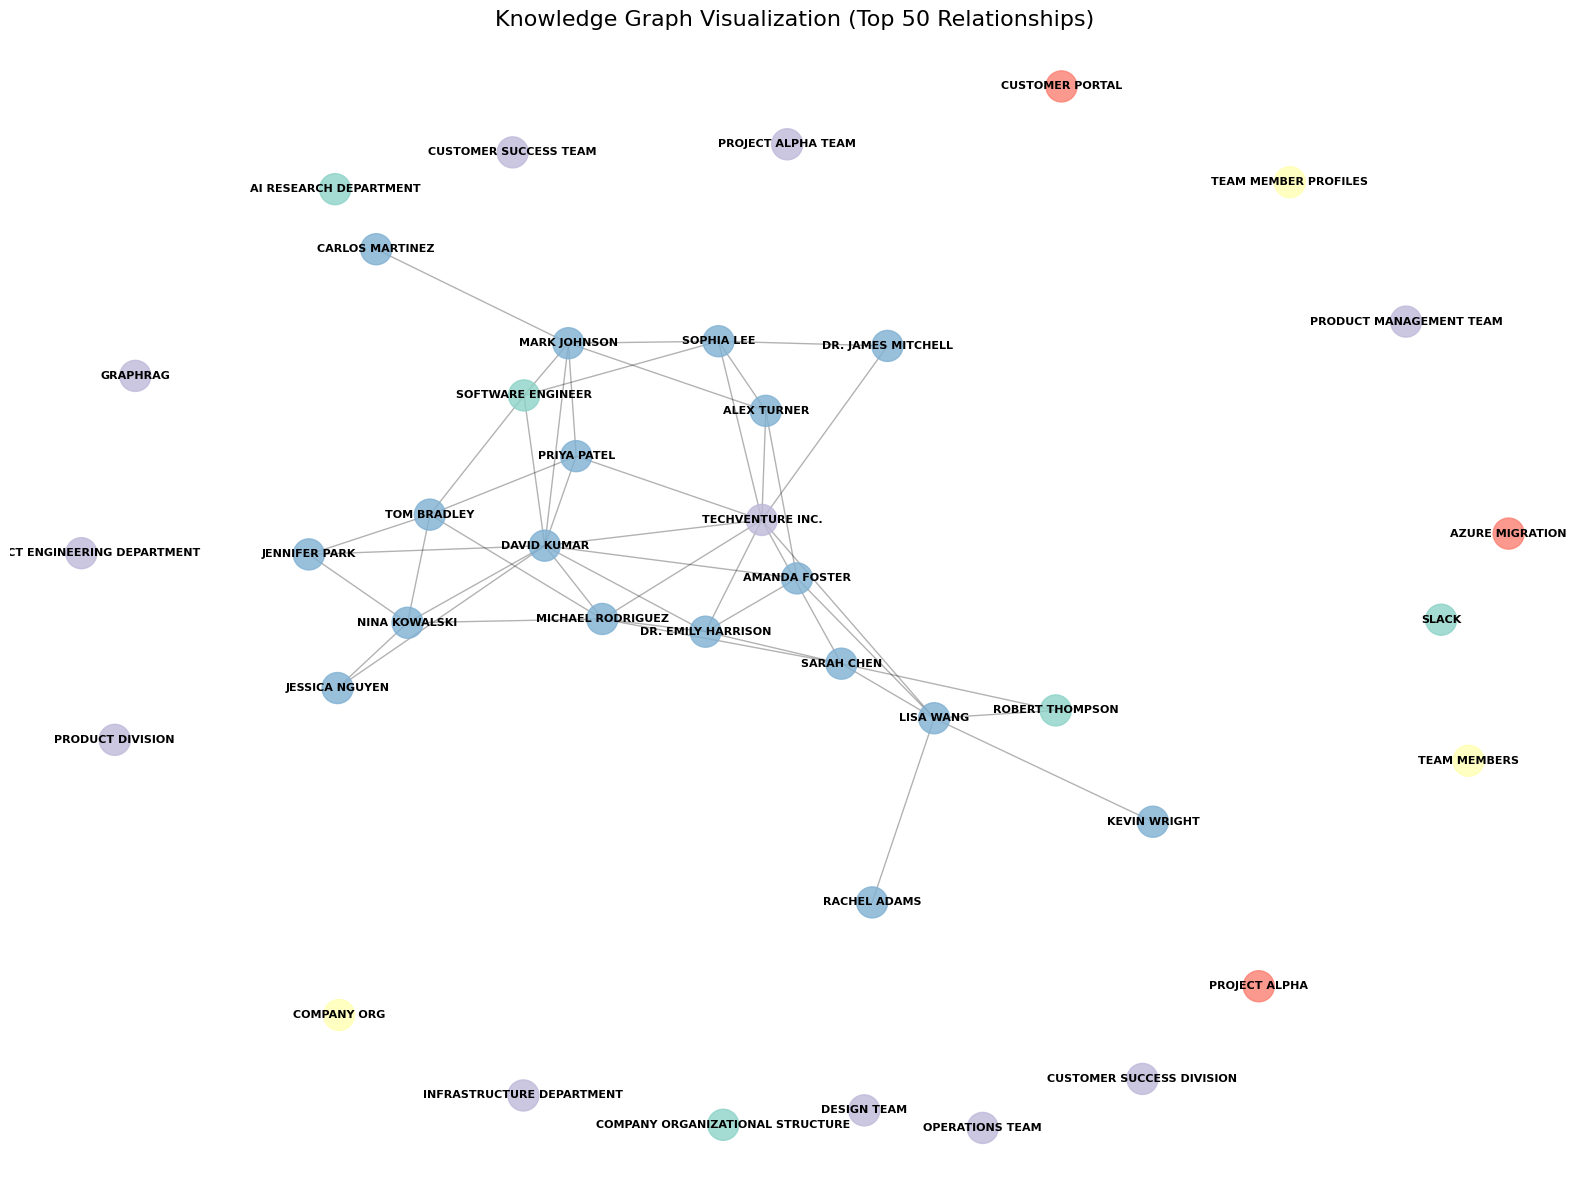


🎨 Legend:
   : 5 nodes
   DOCUMENT: 3 nodes
   ORGANIZATION: 11 nodes
   EVENT: 3 nodes
   PERSON: 18 nodes


In [8]:
# Visualize the graph
if G.number_of_nodes() == 0:
    print("⚠️  No nodes to visualize. Check if entities and relationships were loaded correctly.")
else:
    plt.figure(figsize=(16, 12))

    # Use spring layout for positioning
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Color nodes by entity type - use 'title' column in v1.2.0
    entity_types = entities_df.set_index('title')['type'].to_dict()
    node_colors = [entity_types.get(node, 'unknown') for node in G.nodes()]

    # Create color map
    unique_types = list(set(node_colors))
    color_map = plt.cm.Set3(range(len(unique_types)))
    type_to_color = {t: color_map[i] for i, t in enumerate(unique_types)}
    node_colors_rgb = [type_to_color[t] for t in node_colors]

    # Draw network
    nx.draw_networkx_nodes(G, pos, node_color=node_colors_rgb, node_size=500, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=1)
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    plt.title("Knowledge Graph Visualization (Top 50 Relationships)", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Legend
    print("\n🎨 Legend:")
    for entity_type in unique_types:
        count = sum(1 for t in node_colors if t == entity_type)
        print(f"   {entity_type}: {count} nodes")

## 4. Explore Communities

In [9]:
# Load community reports (GraphRAG v1.2.0 uses create_final_community_reports.parquet)
communities_df = pd.read_parquet(output_dir / "create_final_community_reports.parquet")

print(f"🏘️  Total Communities: {len(communities_df)}")
print(f"\n📋 Community Levels:")
if 'level' in communities_df.columns:
    print(communities_df['level'].value_counts())
else:
    print("No level information found")

communities_df.head()

🏘️  Total Communities: 8

📋 Community Levels:
level
0    5
1    3
Name: count, dtype: int64


,id,human_readable_id,community,parent,level,title,summary,full_content,rank,rank_explanation,findings,full_content_json,period,size
0,cd171cab10884199a1329566330fd8c2,5,5,3,1,TechVenture Inc. AI Leadership,The community is centered around TechVenture I...,# TechVenture Inc. AI Leadership\n\nThe commun...,8.5,The impact severity rating is high due to the ...,[{'explanation': 'Dr. Emily Harrison is a cent...,"{\n ""title"": ""TechVenture Inc. AI Leadershi...",2026-01-30,3
1,292afa71324047fbb785be446ef1b704,6,6,3,1,TechVenture Inc. Infrastructure and Azure Migr...,The community is centered around TechVenture I...,# TechVenture Inc. Infrastructure and Azure Mi...,7.5,The impact severity rating is high due to the ...,[{'explanation': 'Jennifer Park is a pivotal f...,"{\n ""title"": ""TechVenture Inc. Infrastructu...",2026-01-30,3
2,9858e6f7db524a6bb5603676c313f1fa,7,7,3,1,TechVenture Inc. and Project Alpha,The community is centered around TechVenture I...,# TechVenture Inc. and Project Alpha\n\nThe co...,8.5,The impact severity rating is high due to the ...,[{'explanation': 'David Kumar is a pivotal fig...,"{\n ""title"": ""TechVenture Inc. and Project ...",2026-01-30,5
3,821bf2e899714965ba9f1eb273510c87,0,0,-1,0,TechVenture Inc. and Project Alpha,TechVenture Inc. is a mid-sized technology com...,# TechVenture Inc. and Project Alpha\n\nTechVe...,7.5,The impact severity rating is high due to Tech...,[{'explanation': 'TechVenture Inc. is a mid-si...,"{\n ""title"": ""TechVenture Inc. and Project ...",2026-01-30,9
4,89932be8496641249c352f654445362c,1,1,-1,0,TechVenture Inc. and Project Alpha,The community is centered around TechVenture I...,# TechVenture Inc. and Project Alpha\n\nThe co...,7.5,The impact severity rating is high due to the ...,[{'explanation': 'Amanda Foster is a pivotal f...,"{\n ""title"": ""TechVenture Inc. and Project ...",2026-01-30,6


In [10]:
# Show sample community summaries
print("📖 Sample Community Summaries:\n")

for idx, row in communities_df.head(3).iterrows():
    community_id = row.get('community', row.get('id', 'Unknown'))
    level = row.get('level', 'N/A')
    print(f"Community {community_id} (Level {level}):")
    print(f"Title: {row.get('title', 'N/A')}")
    summary = row.get('summary', row.get('full_content', 'N/A'))
    if isinstance(summary, str) and len(summary) > 200:
        print(f"Summary: {summary[:200]}...")
    else:
        print(f"Summary: {summary}")
    print("\n" + "="*60 + "\n")

📖 Sample Community Summaries:

Community 5 (Level 1):
Title: TechVenture Inc. AI Leadership
Summary: The community is centered around TechVenture Inc.'s AI leadership, primarily involving Dr. Emily Harrison and Michael Rodriguez. Dr. Harrison leads the AI Research Department and Project Alpha, while ...


Community 6 (Level 1):
Title: TechVenture Inc. Infrastructure and Azure Migration
Summary: The community is centered around TechVenture Inc.'s Infrastructure Department, led by Jennifer Park, who plays a crucial role in overseeing infrastructure and cloud services. The department is involve...


Community 7 (Level 1):
Title: TechVenture Inc. and Project Alpha
Summary: The community is centered around TechVenture Inc., with a focus on Project Alpha. Key entities include David Kumar, Priya Patel, Jessica Nguyen, Tom Bradley, and Nina Kowalski, all of whom play signif...




## 5. Entity Analysis

Find the most connected entities (highest degree centrality).

In [11]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Sort by centrality
top_entities = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("⭐ Top 10 Most Connected Entities:\n")
for entity, centrality in top_entities:
    entity_type = entity_types.get(entity, 'unknown')
    print(f"   {entity} ({entity_type}): {centrality:.3f}")

⭐ Top 10 Most Connected Entities:

   DAVID KUMAR (PERSON): 0.256
   TECHVENTURE INC. (ORGANIZATION): 0.231
   MICHAEL RODRIGUEZ (PERSON): 0.154
   LISA WANG (PERSON): 0.154
   MARK JOHNSON (PERSON): 0.154
   SARAH CHEN (PERSON): 0.128
   DR. EMILY HARRISON (PERSON): 0.128
   SOPHIA LEE (PERSON): 0.128
   TOM BRADLEY (PERSON): 0.128
   NINA KOWALSKI (PERSON): 0.128


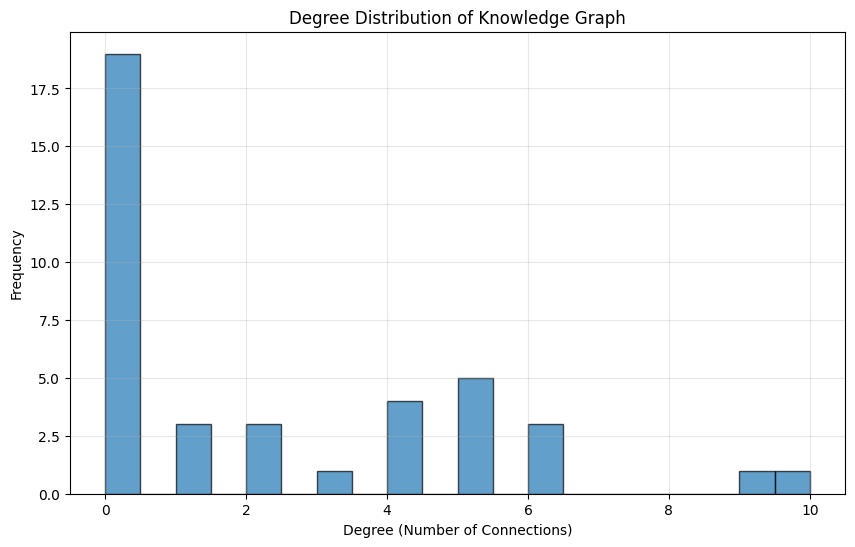


📊 Degree Statistics:
   Mean: 2.25
   Max: 10
   Min: 0


In [12]:
# Visualize degree distribution
degrees = [G.degree(n) for n in G.nodes()]

plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Degree (Number of Connections)')
plt.ylabel('Frequency')
plt.title('Degree Distribution of Knowledge Graph')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n📊 Degree Statistics:")
print(f"   Mean: {sum(degrees)/len(degrees):.2f}")
print(f"   Max: {max(degrees)}")
print(f"   Min: {min(degrees)}")

## 6. Search Examples

Test some search queries (requires running search scripts).

In [ ]:
print("💡 Try these search queries using the PowerShell script:\n")
print("Local Search (specific questions):")
print('  .\\run_query.ps1 -Method local -Query "Who leads Project Alpha?"')
print('  .\\run_query.ps1 -Method local -Query "What technologies are used in Project Alpha?"')
print('  .\\run_query.ps1 -Method local -Query "What is David Kumar working on?"')
print("\nGlobal Search (thematic questions):")
print('  .\\run_query.ps1 -Method global -Query "What are the main projects?"')
print('  .\\run_query.ps1 -Method global -Query "Summarize the organizational structure"')
print('  .\\run_query.ps1 -Method global -Query "What technologies are being used?"')

## Next Steps

1. **Explore Different Entity Types:** Filter the graph by specific entity types
2. **Analyze Specific Communities:** Deep dive into community structures
3. **Test Search Queries:** Use local and global search to query the graph
4. **Add More Documents:** Expand the knowledge graph with additional content

For Week 2, we'll explore:
- Advanced query patterns
- Custom entity types
- Multi-hop reasoning
- Performance optimization